In [2]:
pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 15.4 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=47a023bde1fbae6c4ca5a4055cad85a65dc90dd6dfdaa7693a2816abf4d7a28c
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models
Note: you may need to restart the kernel to use updated packages.


In [4]:
import shutil
from pathlib import Path

def merge_subfolders(first_root, second_root, common_folder, num_first=5):
    first_root  = Path(first_root)
    second_root = Path(second_root)
    common      = Path(common_folder)

    # ensure output exists
    common.mkdir(parents=True, exist_ok=True)

    # 1) pick first N subfolders from first_root
    subs1 = sorted([d for d in first_root.iterdir() if d.is_dir()])[:num_first]
    for src in subs1:
        dst = common / src.name
        if dst.exists():
            print(f"⚠️  Skipping {dst} (already exists)")
            continue
        shutil.copytree(src, dst)
        print(f"✅  Copied {src} → {dst}")

    # 2) copy the entire second_root as a subfolder
    dst2 = common / second_root.name
    if dst2.exists():
        print(f"⚠️  Skipping {dst2} (already exists)")
    else:
        shutil.copytree(second_root, dst2)
        print(f"✅  Copied {second_root} → {dst2}")

if __name__ == "__main__":
    merge_subfolders(
        first_root    = r"/kaggle/input/face-recognition-dataset/Original Images/Original Images",
        second_root   = r"/kaggle/input/ahmed-karous",
        common_folder = r"commonFolder",
        num_first     = 5
    )


✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Akshay Kumar → commonFolder/Akshay Kumar
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Alexandra Daddario → commonFolder/Alexandra Daddario
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Alia Bhatt → commonFolder/Alia Bhatt
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Amitabh Bachchan → commonFolder/Amitabh Bachchan
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Andy Samberg → commonFolder/Andy Samberg
✅  Copied /kaggle/input/ahmed-karous → commonFolder/ahmed-karous


### 

In [5]:
import os
from imutils import paths
import face_recognition
import pickle
import cv2

DATASET_PATH = "/kaggle/working/commonFolder"

print("[INFO] start processing faces...")
imagePaths = list(paths.list_images(DATASET_PATH))
knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):
    print(f"[INFO] processing image {i + 1}/{len(imagePaths)}")
    name = imagePath.split(os.path.sep)[-2]  # Extract folder name as label
    
    image = cv2.imread(imagePath)
    if image is None:
        print(f"[WARNING] Could not read image {imagePath}, skipping.")
        continue

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(rgb, model="hog")
    encodings = face_recognition.face_encodings(rgb, boxes)

    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)

print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
with open("encodings.pickle", "wb") as f:
    f.write(pickle.dumps(data))

print("[INFO] Training complete. Encodings saved to 'encodings.pickle'")


[INFO] start processing faces...
[INFO] processing image 1/399
[INFO] processing image 2/399
[INFO] processing image 3/399
[INFO] processing image 4/399
[INFO] processing image 5/399
[INFO] processing image 6/399
[INFO] processing image 7/399
[INFO] processing image 8/399
[INFO] processing image 9/399
[INFO] processing image 10/399
[INFO] processing image 11/399
[INFO] processing image 12/399
[INFO] processing image 13/399
[INFO] processing image 14/399
[INFO] processing image 15/399
[INFO] processing image 16/399
[INFO] processing image 17/399
[INFO] processing image 18/399
[INFO] processing image 19/399
[INFO] processing image 20/399
[INFO] processing image 21/399
[INFO] processing image 22/399
[INFO] processing image 23/399
[INFO] processing image 24/399
[INFO] processing image 25/399
[INFO] processing image 26/399
[INFO] processing image 27/399
[INFO] processing image 28/399
[INFO] processing image 29/399
[INFO] processing image 30/399
[INFO] processing image 31/399
[INFO] processi

### Test on single image 

In [6]:
import face_recognition
import cv2
import pickle
import os

# Load encodings
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

# Replace this with your actual image
image_path = "/kaggle/working/commonFolder/ahmed-karous/ahmed_20250415_164658.jpg"

# Check file exists
if not os.path.exists(image_path):
    print(f"[ERROR] Image not found at: {image_path}")
    exit()

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to read image: {image_path}")
    exit()

# Convert to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect and encode
boxes = face_recognition.face_locations(rgb, model="hog")
encodings = face_recognition.face_encodings(rgb, boxes)

for (box, encoding) in zip(boxes, encodings):
    matches = face_recognition.compare_faces(data["encodings"], encoding)
    name = "Unknown"

    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}
        for i in matchedIdxs:
            counts[data["names"][i]] = counts.get(data["names"][i], 0) + 1
        name = max(counts, key=counts.get)

    # Draw result
    (top, right, bottom, left) = box
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

cv2.imwrite("output.jpg", image)
print("Output image saved to output.jpg")


Output image saved to output.jpg


In [7]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9901639344262295,
 'val_accuracy': 1.0,
 'confusion_matrix': array([[13,  0,  0,  0,  0,  0],
        [ 0, 23,  0,  0,  0,  0],
        [ 0,  0, 21,  0,  0,  0],
        [ 0,  0,  0, 19,  0,  0],
        [ 0,  0,  0,  0, 23,  0],
        [ 0,  0,  0,  0,  0,  3]]),
 'labels': array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
        'Amitabh Bachchan', 'Andy Samberg', 'ahmed-karous'], dtype='<U18'),
 'model_path': '/kaggle/working/face_classifier.joblib'}

In [13]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9934426229508196,
 'val_accuracy': 0.9901960784313726,
 'confusion_matrix': array([[15,  0,  0,  0,  0,  0],
        [ 1, 19,  0,  0,  0,  0],
        [ 0,  0, 21,  0,  0,  0],
        [ 0,  0,  0, 22,  0,  0],
        [ 0,  0,  0,  0, 20,  0],
        [ 0,  0,  0,  0,  0,  4]]),
 'labels': array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
        'Amitabh Bachchan', 'Andy Samberg', 'ahmed-karous'], dtype='<U18'),
 'model_path': '/kaggle/working/face_classifier.joblib'}

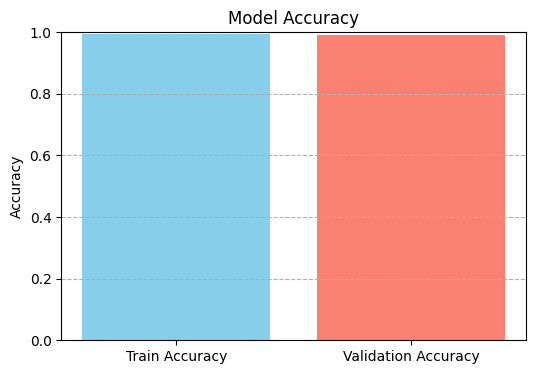

In [14]:
# Accuracy comparison bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--')
plt.show()

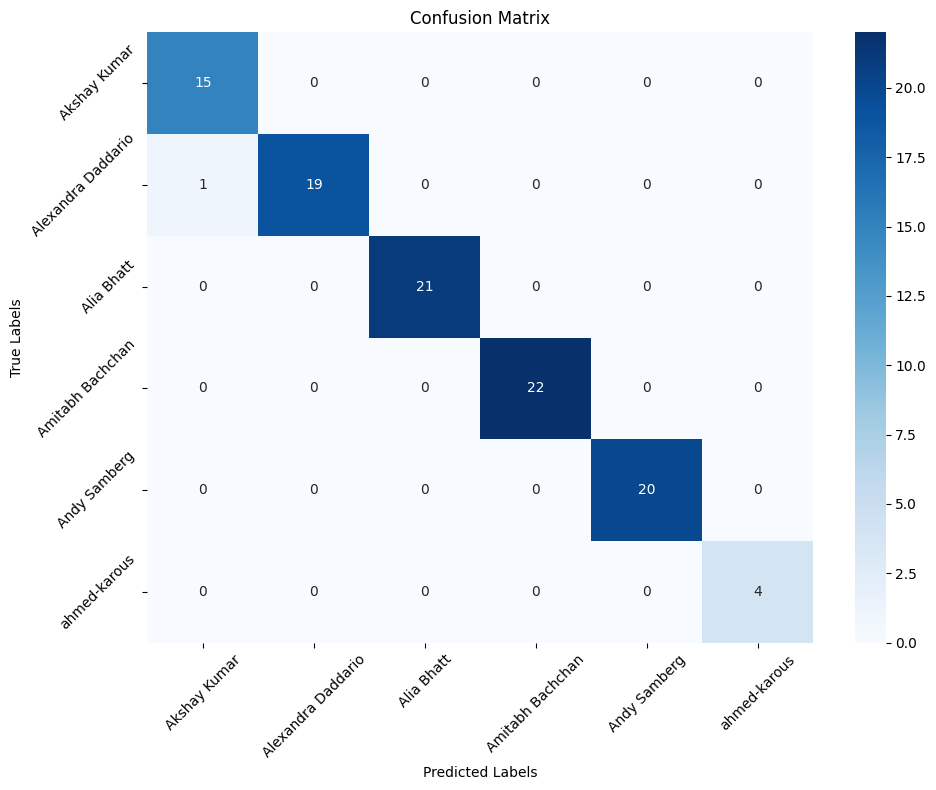

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))


Classification Report:

                    precision    recall  f1-score   support

      Akshay Kumar       1.00      0.90      0.95        10
Alexandra Daddario       1.00      1.00      1.00         7
        Alia Bhatt       0.70      1.00      0.82         7
  Amitabh Bachchan       1.00      1.00      1.00        13
      Andy Samberg       1.00      1.00      1.00        16
    Anushka Sharma       1.00      0.90      0.95        10
     Billie Eilish       0.92      1.00      0.96        11
         Brad Pitt       1.00      1.00      1.00        18
    Camila Cabello       1.00      0.95      0.97        19
   Charlize Theron       1.00      1.00      1.00         7
       Claire Holt       1.00      0.91      0.95        11
      Courtney Cox       1.00      1.00      1.00        11
    Dwayne Johnson       0.78      1.00      0.88         7
   Elizabeth Olsen       1.00      1.00      1.00         9
   Ellen Degeneres       1.00      0.93      0.96        14
      Henry Cav

In [9]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.14.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input

from tensorflow.keras.utils import to_categorical
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load encodings
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Filter classes with at least 2 samples
from collections import Counter
class_counts = Counter(y)
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_cat = to_categorical(y_encoded)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_cat, test_size=0.25, random_state=42, stratify=y_cat
)

# Build model
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Save model
model.save("face_classifier_nn.h5")

# === Plot training history ===
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50


E0000 00:00:1748158340.982415     112 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.2.1 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1748158341.114842     112 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.2.1 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_35/98592795.py", line 54, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_4450]